In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install facenet-pytorch
!pip install torch
!pip install torchvision
!pip install numpy
!pip install Pillow
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:00


In [3]:
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torchvision import datasets, transforms
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt


from torch.optim.lr_scheduler import StepLR

In [4]:

data_dir = '/kaggle/input/dataset-deepfake/deepfake_dataset'

batch_size = 30
epochs = 20
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

# Adjusting the transformation pipeline
trans = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir, transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(dataset, num_workers=workers, batch_size=batch_size,
                          sampler=SubsetRandomSampler(train_inds))
val_loader = DataLoader(dataset, num_workers=workers, batch_size=batch_size,
                        sampler=SubsetRandomSampler(val_inds))

resnet = InceptionResnetV1(classify=True, pretrained='vggface2',
                           num_classes=len(dataset.class_to_idx)).to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.002)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1) #dgfdgh

loss_fn = torch.nn.CrossEntropyLoss()


epoch_losses = []
epoch_accuracies = []

Running on device: cuda:0


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [5]:
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 10)

    resnet.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    for i, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate and print the training progress
        progress_percentage = (i / total_batches) * 100
        print(f'\rTraining progress: {progress_percentage:.2f}%', end='')

    average_epoch_loss = running_loss / total_batches
    epoch_losses.append(average_epoch_loss)
    print(f'\nAverage loss for epoch: {average_epoch_loss}')

    print('\nTraining step done.')

    # Validation step
    resnet.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    epoch_accuracies.append(accuracy)
    print(f'\nAccuracy on validation set: {accuracy}%')
    
    scheduler.step()

    # Print learning rate for verification
    print(f"Current learning rate: {scheduler.get_last_lr()}")

# Save the model after training
model_save_path = 'my_own_model25ola.pt'
os.makedirs('models', exist_ok=True)
torch.save(resnet.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Epoch 1/20
----------
Training progress: 100.00%
Average loss for epoch: 0.38436405803014567

Training step done.

Accuracy on validation set: 49.84642857142857%
Current learning rate: [0.002]

Epoch 2/20
----------
Training progress: 100.00%
Average loss for epoch: 0.09374196412618933

Training step done.

Accuracy on validation set: 50.15357142857143%
Current learning rate: [0.002]

Epoch 3/20
----------
Training progress: 100.00%
Average loss for epoch: 0.04191111660030773

Training step done.

Accuracy on validation set: 49.84642857142857%
Current learning rate: [0.002]

Epoch 4/20
----------
Training progress: 100.00%
Average loss for epoch: 0.026476842681539072

Training step done.

Accuracy on validation set: 49.84642857142857%
Current learning rate: [0.002]

Epoch 5/20
----------
Training progress: 100.00%
Average loss for epoch: 0.018720311682283056

Training step done.

Accuracy on validation set: 50.15357142857143%
Current learning rate: [0.0002]

Epoch 6/20
----------
Trai

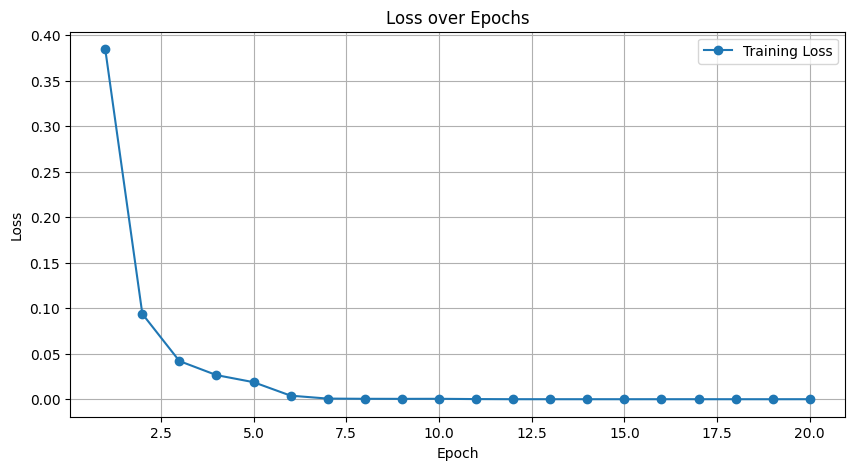

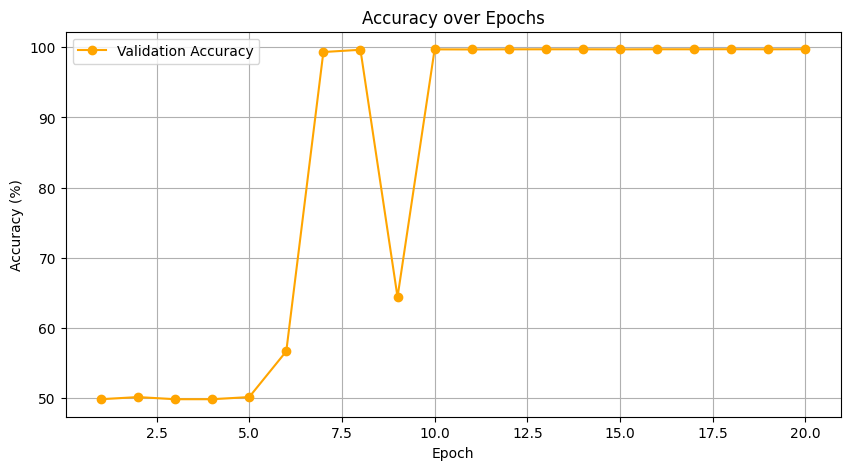

In [6]:
#visulaztion over matplotlib
# Plotting the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), epoch_losses, marker='o', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), epoch_accuracies, marker='o', color='orange', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


# Function to predict a single image
def predict_single_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    return idx_to_class[predicted.item()]

# Predicting a single image
image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00001.jpg'
predicted_class = predict_single_image(image_path, resnet, trans, device)
print(f'Predicted class: {predicted_class}')

image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00004.jpg'
predicted_class = predict_single_image(image_path, resnet, trans, device)
print(f'Predicted class: {predicted_class}')

image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00JEP4Z36Z.jpg'
predicted_class = predict_single_image(image_path, resnet, trans, device)
print(f'Predicted class: {predicted_class}')